In [1]:
import os
os.getcwd()
os.chdir("/Users/hazel/Dropbox/desktop/CSE283/proj_CSE283/breast_cancer_classifier/")
os.getcwd()

'/Users/hazel/Dropbox/desktop/CSE283/proj_CSE283/breast_cancer_classifier'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold

train_path = "./data/combined_tpm_5000genes.csv"
valid_path = "./data/validation_dataset.csv"

df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)

FEATURE_EXCLUDE = ["target", "condition"]

X_train = df_train.drop(columns=FEATURE_EXCLUDE).values
y_train = df_train["target"].values.astype(int)
print(X_train.shape)
print(pd.Series(y_train).value_counts().sort_index())
X_valid = df_valid.drop(columns=FEATURE_EXCLUDE).values
print({X_valid.shape})
y_valid = df_valid["target"].values.astype(int)
print(pd.Series(y_train).value_counts().sort_index())


(128, 5000)
0    32
1    96
Name: count, dtype: int64
{(161, 5000)}
0    32
1    96
Name: count, dtype: int64


NOTE: swapped the training and Training sets (trained on the original valid set, validated on the original training set)

In [5]:
# Elastic-Net + CV
# alpha (glmnet) ↔ l1_ratio  in scikit-learn
l1_grid = np.linspace(0, 1, 11)           # 0 = Ridge, 1 = Lasso
C_grid  = np.logspace(-4, 2, 15)          # inverse λ: 1e-4 … 1e2
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        penalty        = "elasticnet",
        solver         = "saga",
        max_iter       = 5000,
        n_jobs         = -1,
        cv             = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        Cs             = C_grid,
        l1_ratios      = l1_grid,
        scoring        = "roc_auc",
        refit          = True,
    ))
])

pipe.fit(X_train, y_train)
# pipe.fit(X_valid, y_valid)

best_clf = pipe.named_steps["clf"]
best_l1_ratio = float(best_clf.l1_ratio_[0])      
best_C        = float(best_clf.C_[0])             

print(f"Best l1_ratio (alpha) : {best_l1_ratio:.3f}") #0.000
print(f"Best C (1/lambda)     : {best_C:.4g}") #0.001931 #0.01389


Best l1_ratio (alpha) : 0.000
Best C (1/lambda)     : 0.001931


In [ ]:
import joblib

# 保存整个pipeline
# joblib.dump(pipe, './models/elastic_net_model.pkl')

# 加载模型
# pipe = joblib.load('EN_model_ori.pkl')

# 使用加载的模型进行预测
# predictions = pipe.predict(X_test)

['./models/elastic_net_model.pkl']


Training Accuracy : 1.0000
Training AUC      : 1.0000

Classification Report (Training Set):
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        32
           1     1.0000    1.0000    1.0000        96

    accuracy                         1.0000       128
   macro avg     1.0000    1.0000    1.0000       128
weighted avg     1.0000    1.0000    1.0000       128

Confusion Matrix (Training Set):
 [[32  0]
 [ 0 96]]


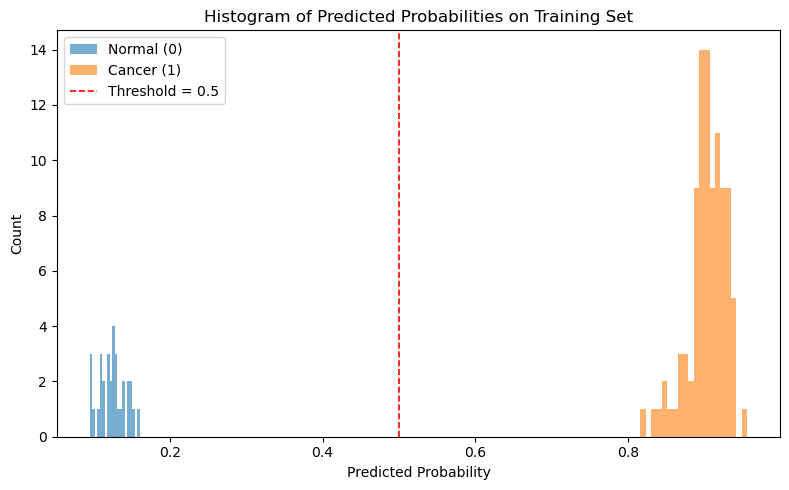

In [ ]:
# evaluate on training set

y_train_prob = pipe.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob > 0.5).astype(int)
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

train_acc  = accuracy_score(y_train, y_train_pred)
train_auc  = roc_auc_score(y_train, y_train_prob)
train_report_txt = classification_report(y_train, y_train_pred, digits=4)
train_conf_mat   = confusion_matrix(y_train, y_train_pred)

print(f"\nTraining Accuracy : {train_acc:.4f}")
print(f"Training AUC      : {train_auc:.4f}")
print("\nClassification Report (Training Set):\n", train_report_txt)
print("Confusion Matrix (Training Set):\n", train_conf_mat)

plt.figure(figsize=(8, 5))
plt.hist(
    y_train_prob[y_train == 0],
    bins=20, alpha=0.6, label="Normal (0)"
)
plt.hist(
    y_train_prob[y_train == 1],
    bins=20, alpha=0.6, label="Cancer (1)"
)
plt.axvline(0.5, color="red", linestyle="--", lw=1.2, label="Threshold = 0.5")
plt.title("Histogram of Predicted Probabilities on Training Set")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


Validation Accuracy : 0.5466
Validation AUC      : 0.6600

Classification Report:
               precision    recall  f1-score   support

           0     0.5862    0.2179    0.3178        78
           1     0.5379    0.8554    0.6605        83

    accuracy                         0.5466       161
   macro avg     0.5620    0.5367    0.4891       161
weighted avg     0.5613    0.5466    0.4944       161

Confusion Matrix:
 [[17 61]
 [12 71]]


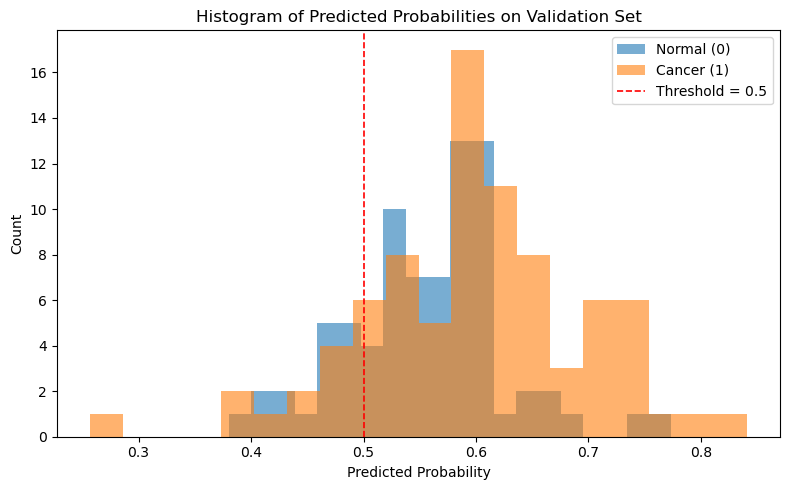

In [9]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
y_valid_prob  = pipe.predict_proba(X_valid)[:, 1]
y_valid_pred  = (y_valid_prob > 0.5).astype(int)

valid_acc  = accuracy_score(y_valid, y_valid_pred)
valid_auc  = roc_auc_score(y_valid, y_valid_prob)
report_txt = classification_report(y_valid, y_valid_pred, digits=4)
conf_mat   = confusion_matrix(y_valid, y_valid_pred)

print(f"\nValidation Accuracy : {valid_acc:.4f}")
print(f"Validation AUC      : {valid_auc:.4f}")
print("\nClassification Report:\n", report_txt)
print("Confusion Matrix:\n", conf_mat)

plt.figure(figsize=(8, 5))
plt.hist(
    y_valid_prob[y_valid == 0],
    bins=20, alpha=0.6, label="Normal (0)"
)
plt.hist(
    y_valid_prob[y_valid == 1],
    bins=20, alpha=0.6, label="Cancer (1)"
)
plt.axvline(0.5, color="red", linestyle="--", lw=1.2, label="Threshold = 0.5")
plt.title("Histogram of Predicted Probabilities on Validation Set")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

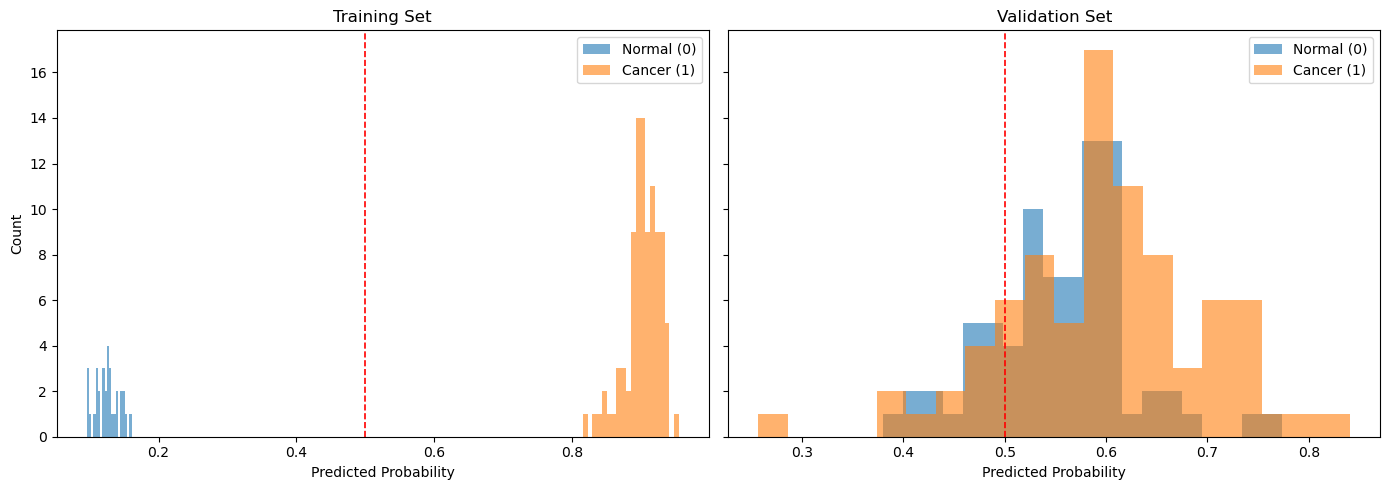

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Training
axes[0].hist(y_train_prob[y_train == 0], bins=20, alpha=0.6, label="Normal (0)")
axes[0].hist(y_train_prob[y_train == 1], bins=20, alpha=0.6, label="Cancer (1)")
axes[0].axvline(0.5, color="red", linestyle="--", lw=1.2)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Predicted Probability")
axes[0].set_ylabel("Count")
axes[0].legend()

# Validation
axes[1].hist(y_valid_prob[y_valid == 0], bins=20, alpha=0.6, label="Normal (0)")
axes[1].hist(y_valid_prob[y_valid == 1], bins=20, alpha=0.6, label="Cancer (1)")
axes[1].axvline(0.5, color="red", linestyle="--", lw=1.2)
axes[1].set_title("Validation Set")
axes[1].set_xlabel("Predicted Probability")
axes[1].legend()

plt.tight_layout()
plt.show()

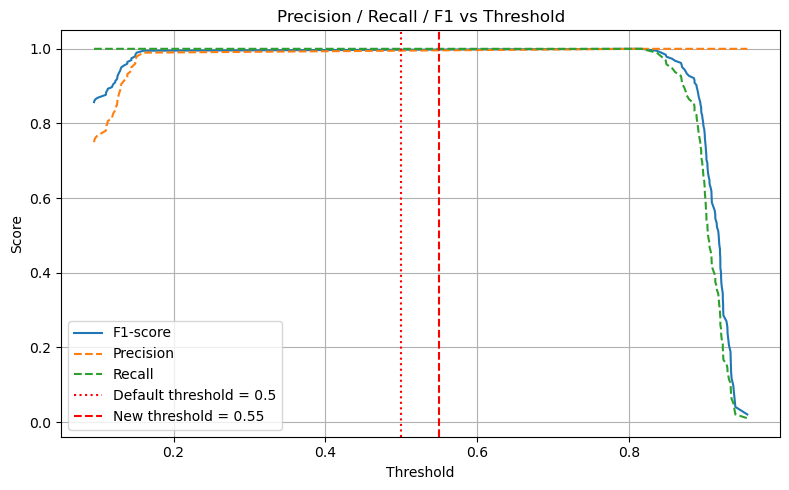

In [11]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_train, y_train_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-10)

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.plot(thresholds, prec[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, rec[:-1], label="Recall", linestyle="--")
plt.axvline(0.5, color='red', linestyle=':', label="Default threshold = 0.5")
plt.axvline(0.55, color='red', linestyle='--', label="New threshold = 0.55")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Set thresh=0.55